# Исследование надежности заемщиков.

### Цели исследования:
- Обработать данные: найти и обработать аномалии, заменить пропуски, решить проблему с дубликатами
- На основе очищенных данных сделать выводы о надежности различных категорий клиентов

### Шаг 1. Обзор данных

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
import numpy as np

import os

In [23]:
# чтение файла с данными и сохранение в df
local_path = '../datasets/credit_scoring.csv'
cloud_path = '/datasets/credit_scoring.csv'

if os.path.exists(local_path):
    df = pd.read_csv(local_path)
elif os.path.exists(cloud_path):
    df = pd_read_csv(cloud_path)
else:
    print('Something wrong with path.')


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [26]:
df[['education', 'education_id']].value_counts()

education            education_id
среднее              1               13750
высшее               0                4718
СРЕДНЕЕ              1                 772
Среднее              1                 711
неоконченное высшее  2                 668
ВЫСШЕЕ               0                 274
Высшее               0                 268
начальное            3                 250
Неоконченное высшее  2                  47
НЕОКОНЧЕННОЕ ВЫСШЕЕ  2                  29
НАЧАЛЬНОЕ            3                  17
Начальное            3                  15
ученая степень       4                   4
УЧЕНАЯ СТЕПЕНЬ       4                   1
Ученая степень       4                   1
dtype: int64

In [3]:
# Смотрим на данные
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
# Средний доход по категории занятости

df.groupby('income_type')['total_income'].mean()

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        170898.309923
компаньон          202417.461462
пенсионер          137127.465690
предприниматель    499163.144947
сотрудник          161380.260488
студент             98201.625314
Name: total_income, dtype: float64

In [5]:
df.shape

(21525, 12)

### Шаг 2.1 Заполнение пропусков

In [6]:
# Посмотрим на кол-во пропущенных значений

df.isna().sum().loc[lambda x: x > 0]

days_employed    2174
total_income     2174
dtype: int64

Мы видим, что пропущенные данные действительно есть - в двух столбцах:

1. `days_employed — общий трудовой стаж в днях`

2. `total_income — ежемесячный доход`

Посмотрим на строки, содержащие пропуски:

In [7]:
# опишите, какие пропущенные значения вы обнаружили;

df[df['days_employed'].isna()].sample(5) # берем  sample, для более репрезентативной выборки

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
14489,1,NaN,35,высшее,0,женат / замужем,0,F,компаньон,0,NaN,получение образования
12480,1,NaN,28,неоконченное высшее,2,женат / замужем,0,F,компаньон,0,NaN,ремонт жилью
8011,0,NaN,48,среднее,1,женат / замужем,0,M,пенсионер,0,NaN,покупка жилой недвижимости
9884,0,NaN,55,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,на проведение свадьбы
15037,1,NaN,40,среднее,1,женат / замужем,0,M,компаньон,0,NaN,строительство собственной недвижимости


**Видим, что пустые значения пересекаются в обеих колонках**

**Можно выдвинуть гипотезу, что пропуски в days_employed означают отсутвие опыта, тогда пустой total_income выглядит более логично. Проверим это**



In [8]:
# проверьте, какую долю составляют пропущенные значения в каждом из столбцов с пропусками;

print(f"Доля пропущенных значений в столбце \"стаж в днях\": \
      {df['days_employed'].isna().value_counts(normalize=True)[1]:.2%}")

print(f"Доля пропущенных значений в столбце \"общий доход\": \
      {df['total_income'].isna().value_counts(normalize=True)[1]:.2%}")


#Альтернативный метод подсчета
# display(df['days_employed'].isna().sum() / df.shape[0] * 100)
# df['days_employed'].isna().sum() / df.shape[0] * 100


Доля пропущенных значений в столбце "стаж в днях":       10.10%
Доля пропущенных значений в столбце "общий доход":       10.10%


In [9]:
df[df['days_employed'].isna()].groupby('income_type').agg({'income_type':['count']}).apply(lambda x: x.sort_values(ascending=False))

,income_type
,count
income_type,
сотрудник,1105
компаньон,508
пенсионер,413
госслужащий,147
предприниматель,1


**Мы видим, что среди людей с незаполненным стажем много сотрудников, что логически противоречит друг другу. Поскольку мы работаем с данными банка, можем лишь предположить, что `сотрудники` без опыта и без дохода, это люди, которые не могут документально подтвердить свою занятость и доход**  

**Что касается других категорий, самой странной категорией (в рамках гипотезы) кажется  `госслужащие`. У этих достопочтенных господ не должно быть проблем с подтверждением официального дохода и уж тем более стажа.**

**Вывод: Гипотеза остаётся гипотезой, и, во всяком случае пока, не влияет на дальнейший ход исследований**

**Медиана в данном случае лучше, т.к. устойчива к выбросам в данных, поэтому она, в отличие от среднего, не исказит наши выводы**

In [10]:
df['days_employed'].fillna(df['days_employed'].median(), inplace=True)
df['total_income'].fillna(df['total_income'].median(), inplace=True)

total_nans = df.isna().sum().sum()
print(f"Total nans in data : {total_nans}")

Total nans in data : 0


### Шаг 2.2 Проверка данных на аномалии и исправления.

In [11]:
# Посмотрим ключевые статистики по всем столбцам
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,2.152500e+04
mean,0.538908,56557.335698,43.293380,0.817236,0.972544,0.080883,1.651595e+05
std,1.381587,134922.319298,12.574584,0.548138,1.420324,0.272661,9.786607e+04
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2518.168900,33.000000,1.000000,0.000000,0.000000,1.077982e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-385.106616,53.000000,1.000000,1.000000,0.000000,1.955436e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Видим, что минимальное значение признаков `days employed` и `children` - отрицательные. Это странно, т.к. задолжать детей и стаж - не так легко, как может показаться. Так же есть клиенты с 20 детьми, это довольно много.
Давайте взглянём на аномалии подронее**


In [12]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

**76 семей с 20 детьми - в реальности маловероятно. Давайте сложим аномальные значения(отрицательные дети и 20 детей) и посчитаем их долю**

In [13]:
children_anomaly = df[(df['children'] < 0) | (df['children'] == 20)]
print(f"Доля клиентов с нереалестичными данными о детях: {children_anomaly.shape[0] / df.shape[0]:.2%}")

Доля клиентов с нереалестичными данными о детях: 0.57%


**Процент аномалий небольшой, давайте посмотрим на выборку с аномалиями**

In [14]:
children_anomaly

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
...,...,...,...,...,...,...,...,...,...,...,...,...
21140,-1,-1422.668059,44,среднее,1,женат / замужем,0,F,компаньон,0,169562.091999,операции со своей недвижимостью
21325,20,-601.174883,37,среднее,1,женат / замужем,0,F,компаньон,0,102986.065978,профильное образование
21390,20,-1203.369529,53,среднее,1,женат / замужем,0,M,компаньон,0,145017.937533,покупка жилой недвижимости
21404,20,-494.788448,52,среднее,1,женат / замужем,0,M,компаньон,0,156629.683642,операции со своей недвижимостью


**Видим клиентов в возрасте 21 и 27 лет, с 20 детьми. Это совсем маловероятно. Поскольку процент клиентов с аномалиями признака "дети" небольшой, удалим эти данные**

**p.s. Можно было бы оставить токлько клиентов старше 45 лет, и с 20 детьми, или же заменить все значения на медиану, в данном случае 0, но с моей точки зрения в дальнейшем это может помешать модели сделать правильные выводы и предсказания.**

In [15]:
df = df.drop(children_anomaly.index).reset_index(drop=True)

___


In [16]:
# Посмотрим внимательнее на признак "стаж"
df['days_employed'].describe()

count     21402.000000
mean      56657.941633
std      135021.372877
min      -18388.949901
25%       -2516.257954
50%       -1203.369529
75%        -384.175915
max      401755.400475
Name: days_employed, dtype: float64

In [17]:
#  Посчитаем долю клиентов с отрицательным стажем
print(f"Доля людей с отрицательным значением стажа: {df[df['days_employed'] < 0].shape[0] / df.shape[0]:.2%}")

Доля людей с отрицательным значением стажа: 83.97%


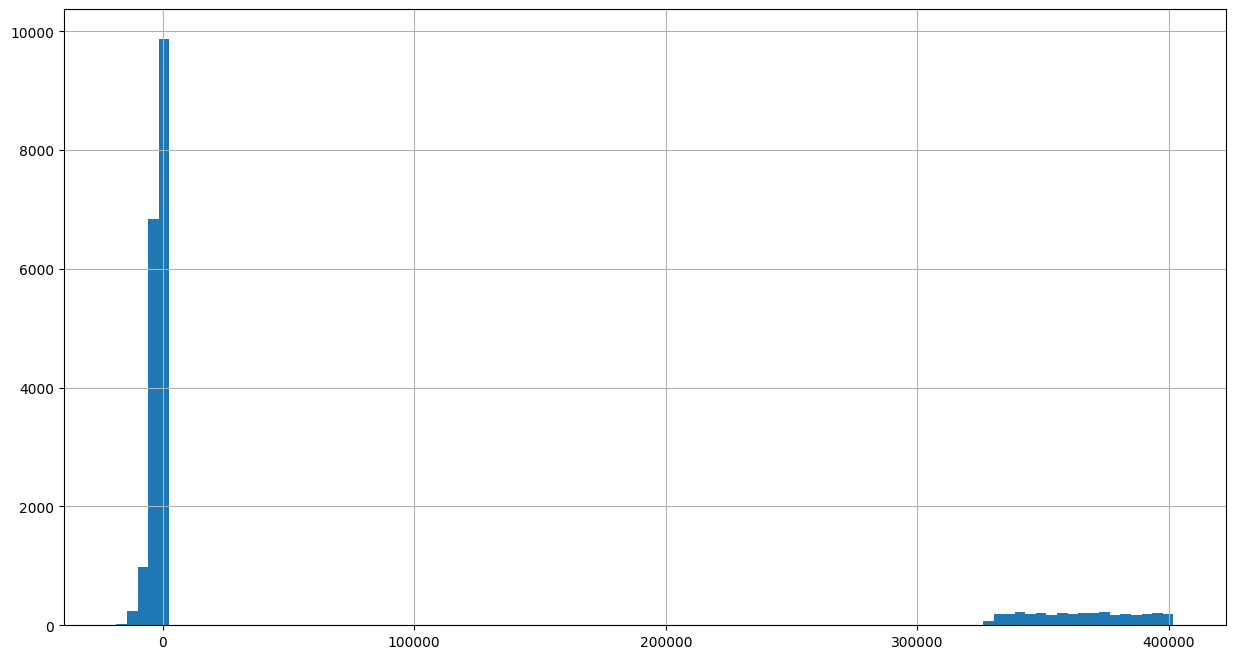

In [20]:
df['days_employed'].hist(bins=100);

**Отрицательное значение стажа имеют 84 процента клиентов, значит это не аномалия.**


1. Возможно за условный 0 банк берет величину, специально рассчитаную, как более вероятную для возврата кредита. Предположим, сотрудники, отработавшие 4 года, по статистике более надёжные, тогда 4 * 365 = 1460. Например какой-то человек отработал только 1 год, тогда значение признака days_employed = 365 - 1460 = -1095
2. Возможно отицательный знак просто случаен. 


**Отрицательные значения заменим модулем числа** 

In [20]:
# Меняем отрицательные значения на модуль
df['days_employed'] = df['days_employed'].agg(abs)

---

In [22]:
employed_anomaly = df[df['days_employed'] > 300000]['days_employed'] / 365 
pd.DataFrame(employed_anomaly.describe())

,days_employed
count,3431.000000
mean,1000.070963
std,57.773886
min,900.626632
25%,949.724236
50%,1000.785268
75%,1050.117236
max,1100.699727


In [23]:
print(f"Доля людей со стажем больше 800 лет: {employed_anomaly.shape[0] / df.shape[0]:.2%}")

Доля людей со стажем больше 800 лет: 16.03%


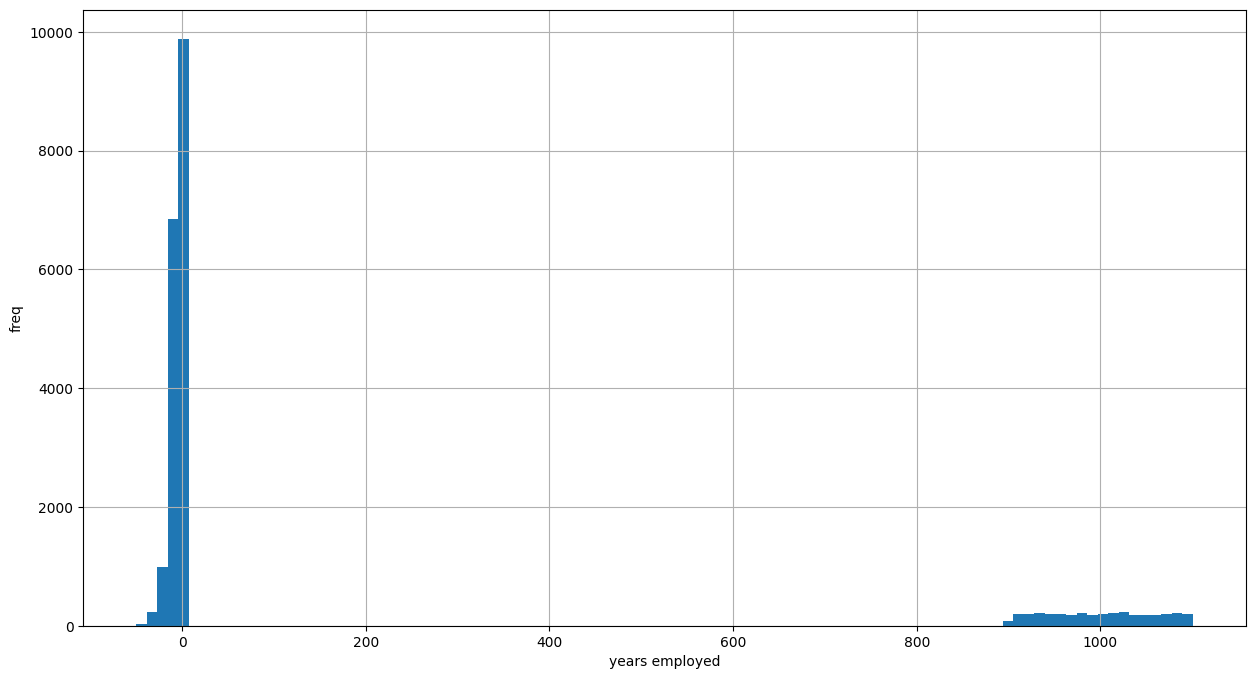

In [21]:
# Проще всего увидеть выбросы на графике. Давайте посмотрим на распределение стажа в выборке


df['days_employed'].apply(lambda x: x / 365).hist(bins=100);
plt.xlabel('years employed');
plt.ylabel('freq');

**3.5 тысячи, всё таки очень много, для наших данных, если данные просто удалить, это может искзить выводы. Заменим эти значения медианным по выборке.**

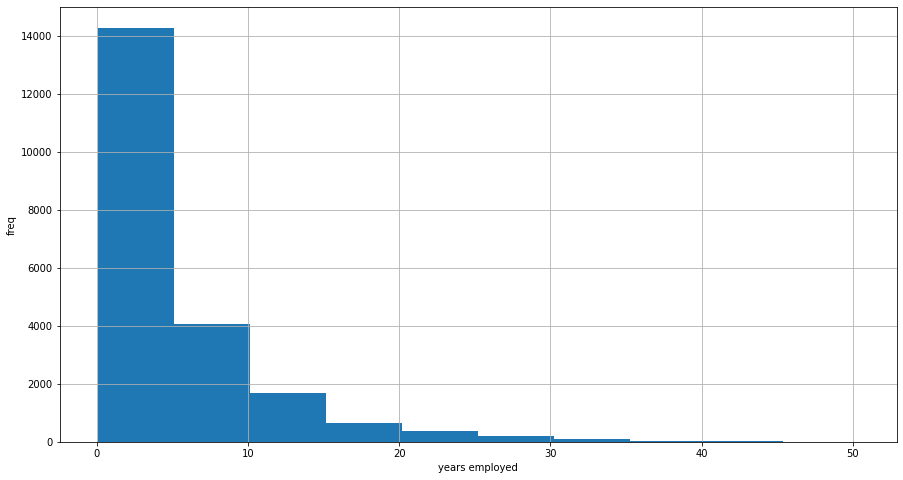

In [25]:
# меняем на медиану
df.loc[employed_anomaly.index, 'days_employed'] = df['days_employed'].median()

# строим график и смотрим на распределение
df['days_employed'].apply(lambda x: x / 365).hist();
plt.xlabel('years employed');
plt.ylabel('freq');

---

In [26]:
# Посмотрим на значения признака Пол
df['gender'].value_counts()

F      14154
M       7247
XNA        1
Name: gender, dtype: int64

**Всего одно значение, посмотрим на него**

In [27]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10646,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


**В других колонках не видно искажений, оставим эту строку**

---

In [28]:
# Посмотрим есть ли заёмщики младше 18 лет
age_anomaly = df[df['dob_years'] < 18]
age_anomaly['dob_years'].value_counts()


0    100
Name: dob_years, dtype: int64

**100 клиентов с ошибкой в столбце "возраст"**

In [67]:
# Создаём словарь, в который записываем медианное значение по типу занятости
median_dict = df.groupby('income_type')['dob_years'].median().to_dict()

# Меняем значения с 0 на медианное, по категории
for k,v in median_dict.items():
    age_anomaly.loc[age_anomaly['income_type'] == k, 'dob_years'] = round(v)

# Заменяем знаения в исходном датафрейме
df.loc[age_anomaly.index] = age_anomaly.copy(deep=True)

# Проверяем, все ли корректно удалили
df[df['dob_years'] < 18]['dob_years'].sum()

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0

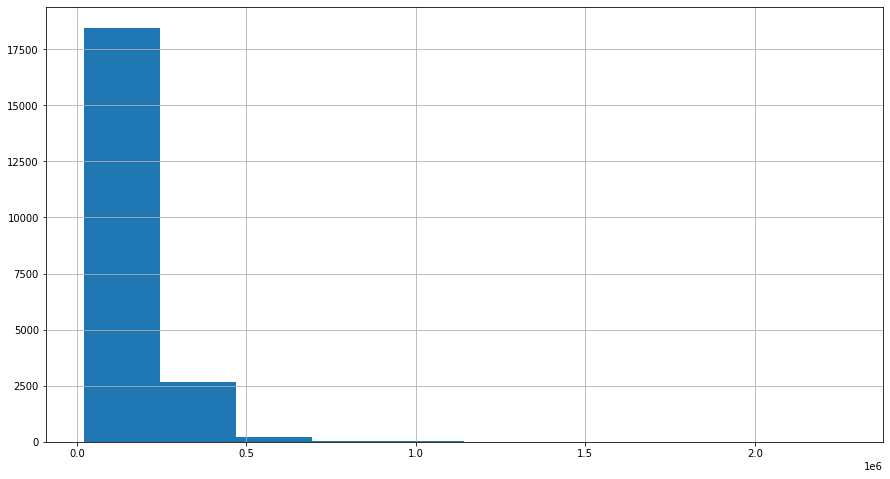

In [68]:
# Посмотрим на распределение признака "ежемесячный доход"
df['total_income'].hist();

**С этим признаком все ок, не видим никаких хвостов**

### Шаг 2.3. Изменение типов данных.

In [29]:
# Замените вещественный тип данных в столбце total_income на целочисленный, например, с помощью метода astype().

df['total_income'] = df['total_income'].astype('int')

df['total_income'].dtype

dtype('int64')

### Шаг 2.4. Удаление дубликатов.

In [30]:
# Посмотрим сколько уникальных категорий есть в столбце education
pd.DataFrame(df['education'].value_counts())

,education
среднее,13667
высшее,4698
СРЕДНЕЕ,766
Среднее,703
неоконченное высшее,665
ВЫСШЕЕ,271
Высшее,268
начальное,250
Неоконченное высшее,47
НЕОКОНЧЕННОЕ ВЫСШЕЕ,29


In [31]:
# Теперь посчитаем кол-во категорий, если привести их к нижнему регистру
pd.DataFrame(df['education'].str.lower().value_counts())

,education
среднее,15136
высшее,5237
неоконченное высшее,741
начальное,282
ученая степень,6


**Ого, в три раза меньше категорий ! Осталось привести их все к "общему знаменателю"**

In [32]:
df['education'] = df['education'].str.lower()

In [33]:
# Ищем неявные дубликаты, связаные с регистром, в других колонках

for col in df.select_dtypes("O").columns:
    all_unique = len(df[col].unique())
    lower_unique = len(df[col].str.lower().unique())
    
    if all_unique == lower_unique: print(f'{col} дубликаты не найдены')
    else: print(f"В колонке есть одинаковые значения ! {df[col].value_counts()}")

education дубликаты не найдены
family_status дубликаты не найдены
gender дубликаты не найдены
income_type дубликаты не найдены
purpose дубликаты не найдены


In [34]:
# Посчитаем общее количество

df.duplicated().sum()

71

In [35]:
# Удаляем явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

**Дубликатов связанных с регистром не нашли, давайте посмотрим на сами категории внутри колонок**

In [36]:
# Уверен есть более изящный способ, но пока так.

for col in df.select_dtypes(include='O').columns:
    display(pd.DataFrame(df[col].value_counts()))


,education
среднее,15075
высшее,5227
неоконченное высшее,741
начальное,282
ученая степень,6


,family_status
женат / замужем,12261
гражданский брак,4134
Не женат / не замужем,2796
в разводе,1189
вдовец / вдова,951


,gender
F,14092
M,7238
XNA,1


,income_type
сотрудник,11015
компаньон,5047
пенсионер,3812
госслужащий,1451
предприниматель,2
безработный,2
в декрете,1
студент,1


,purpose
свадьба,790
на проведение свадьбы,763
сыграть свадьбу,760
операции с недвижимостью,672
покупка коммерческой недвижимости,658
покупка жилья для сдачи,649
операции с жильем,647
операции с коммерческой недвижимостью,645
жилье,641
покупка жилья,640


1. Мы видим, что колонки `education`, `family_status`, `income_type` не содержат скрытых дубликатов.
2. Признак `gender` содержит одно неизвестное значение `XNA`
3. Мы видим много дубликатов в колонке purpose. Видимо при заполнении анкеты люди имели ввиду одно и то же, но по разному описывали


In [38]:
# Посмотрим на строку, значение колонки gender которой содержит значение XNA

df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10629,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


**Кроме значения `gender`, остальные значения выглядят вполне нормально, возможно наш клиент небинарная личность ? Данные удалять не будем**

---

**Видим много неявных дубликатов в категории purpose. В 7 шаге нас попросят написать функцию для обработки таких дубликатов, поэтому пока трогать их не будем**

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [39]:
edu_df = df[['education_id', 'education']].drop_duplicates().reset_index(drop=True)
family_df = df[['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True)


In [40]:
# Удалите из исходного датафрейма столбцы education и family_status
df.drop(columns=['family_status', 'education'], inplace=True)

### Шаг 2.6. Категоризация дохода.

In [41]:
# Разделим доход на категории 
def income_cat(income):
    if income <= 30000: return "E"
    elif 30001 <= income <= 50000: return "D"
    elif 50001 <= income <= 200000: return "C"
    elif 200001 <= income <= 1000000: return "B"
    elif income >= 1000001: return "A"

df['total_income_category']  = df['total_income'].apply(income_cat)

In [42]:
# Проверяем результат
df['total_income_category'].value_counts()

C    15922
B     5013
D      349
A       25
E       22
Name: total_income_category, dtype: int64

### Шаг 2.7. Категоризация целей кредита.

In [59]:
# Воспользуемся стеммингом, для поиска дубликатов

from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 

purpose_values = ['операции с автомобилем',
'операции с недвижимостью',
'проведение свадьбы',
'получение образования'] # Это список категорий, на которые мы заменим значения признака purpose

stemmed_purpose_values = [] # в этом списке будут храниться ключевые стеммы для поиска в столбце purpose

for value in purpose_values:
    stemmed_purpose_values.append(stemmer.stem(value.split()[-1])) # берём именно последнее слово, т.к. оно является ключевым
# print(stemmed_purpose_values)


def lets_stem(query):
    stemmed_query = stemmer.stem(query).split()
    if stemmed_purpose_values[0] in stemmed_query: return purpose_values[0]
    elif stemmed_purpose_values[1] in stemmed_query: return purpose_values[1]
    elif stemmed_purpose_values[2] in stemmed_query: return purpose_values[2]
    elif stemmed_purpose_values[3] in stemmed_query: return purpose_values[3]
        

In [71]:
stemmed_purpose_values

['автомобил', 'недвижим', 'свадьб', 'образован']

In [74]:
for elem in df[df['purpose'].str.contains('ремон')]['purpose']:
    stemmed = stemmer.stem(elem)
    print(stemmed)
    if stemmed_purpose_values[1] in stemmed: print(stemmed)


ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил
ремонт жил

In [75]:
df['purpose_category'] = df['purpose'].apply(lets_stem)

In [81]:
df[df['purpose'].str.contains('ремон')]

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
139,0,1765.557387,29,2,0,M,компаньон,0,196932,ремонт жилью,C,None
163,0,7473.902957,50,1,0,M,сотрудник,0,78975,ремонт жилью,C,None
228,0,1810.868889,60,1,4,F,пенсионер,0,190426,ремонт жилью,C,None
270,3,1872.663186,39,1,0,F,сотрудник,0,102166,ремонт жилью,C,None
276,0,8631.590122,64,1,0,F,сотрудник,0,160814,ремонт жилью,C,None
...,...,...,...,...,...,...,...,...,...,...,...,...
21214,2,223.085545,47,1,0,M,сотрудник,0,273940,ремонт жилью,B,None
21232,0,106.691955,34,1,0,F,компаньон,0,400614,ремонт жилью,B,None
21268,0,6105.851119,58,0,0,F,компаньон,0,111479,ремонт жилью,C,None
21271,1,949.005714,25,1,4,F,сотрудник,0,105262,ремонт жилью,C,None


In [79]:
df.shape

(21331, 12)

In [43]:
df['purpose_category'].value_counts()

операции с недвижимостью    6314
получение образования       3988
операции с автомобилем      3803
проведение свадьбы          2313
Name: purpose_category, dtype: int64

### Ответы на вопросы.

Для ответа на финальные вопросы, посмотрим на сводные таблицы, которые посчитают долю плохих клиентов, не возвращающих долги в срок. Таблицы отсортированы в порядке убывания (от плохих категорий клиентов, к хорошим)


In [44]:
# Для ответа на финальные вопросы, посмотрим на сводные таблицы, которые посчитают долю плохих клиентов, 
# не возвращающих долги в срок. 
# Таблицы отсортированы в порядке убывания (от плохих категорий клиентов, к хорошим)

def custom_pivot(data, target_column, index, aggfunc=['count', 'sum'], count_perc=True):
    pivot = data.pivot_table(values=target_column, index=index, aggfunc=aggfunc)
    if count_perc:
        pivot['perc'] = round(pivot['sum'][target_column] / pivot['count'][target_column]* 100, 2)
    return pivot.sort_values('perc', ascending=False)

In [45]:
pivots_list = ['children', 'total_income_category', 'family_status','purpose_category']
df = df.merge(family_df, on='family_status_id')
for pivot in pivots_list:
    display(custom_pivot(df, 'debt', pivot))

,count,sum,perc
,debt,debt,
children,,,
4,41,4,9.76
2,2052,194,9.45
1,4808,444,9.23
3,330,27,8.18
0,14091,1063,7.54
5,9,0,0.00


,count,sum,perc
,debt,debt,
total_income_category,,,
E,22,2,9.09
C,15922,1353,8.50
A,25,2,8.00
B,5013,354,7.06
D,349,21,6.02


,count,sum,perc
,debt,debt,
family_status,,,
Не женат / не замужем,2796,273,9.76
гражданский брак,4134,385,9.31
женат / замужем,12261,927,7.56
в разводе,1189,84,7.06
вдовец / вдова,951,63,6.62


,count,sum,perc
,debt,debt,
purpose_category,,,
операции с автомобилем,3803,356,9.36
получение образования,3988,369,9.25
проведение свадьбы,2313,183,7.91
операции с недвижимостью,6314,472,7.48


##### Есть ли зависимость между количеством детей и возвратом кредита в срок?


Мы видим определенную зависимость между кол-вом детей и риском невозврата, однако зависимость нелинейна. Наивысший риск невозврата, среди клиентов с 4 детьми, однако среди клиентов с 5ю детьми нет ни одной задолженности. 

##### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Зависимость есть, меньше всего должников, среди вдов и вдовцов. Больше всего - среди холостых. 

##### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Зависимость есть люди с низкими доходами реже возрващают кредит в срок. 

##### Как разные цели кредита влияют на его возврат в срок?

Мы видим, что клиенты, покупающие автомобили в кредит - наименее надёжные заёмщики. 
Те же, кто берут кредит на недвижимость - самые надёжные клиенты. 
Интересно, что люди, берущие кредит на свадьбу - почти такие же надёжные, как и ипотечные клиенты, что противоречит интуитивным выводам, т.к. кажется, что люди, берущие кредит на свадьбу, достаточно безрассудны. 

## Общий вывод:

Вывод
* В процессе обработки данных нам удалось найти пропущенные значения в двух столбцах: days_employed и total_income. Доля пропущенных значений в обоих столбцах составила 10.1 %. 
* Пропущенные значения заменены медианным значением выборки. 
* Так же было обнаружено, что больше всего пропущенных значений стажа у категории «сотрудники», что является логическим противоречием. **На основе имеющихся данных выдвинута гипотеза, о том, что незаполненные значения могут означать невозможность таких клиентов подтвердить свой доход документально. Гипотеза требует подтверждения от заказчика.**


Так же в данных обнаружены следующие аномалии:
* Количество детей принимает отрицательные значения у 47 клиентов и равно 20 у 76 клиентов. Доля таких данных - 0.57 %. Принято решение об удалении этих данных из датасета.
* Так же в колонке стаж обнаружены аномальные значения: отрицательные и непропорционально большие. Отрицательные значения заменены на абсолютные, непропорциональные заменены медианой. Для наглядности построен график
* В колонке «Пол» обнаружено одно нестандартное значение «XNA» Решено оставить его без изменений
* Найдено 100 клиентов со значением 0 признака «возраст». Заменено медианой по категории типа занятости. 
* Построен график распределения признака «Ежемесячный доход», выбросов и аномалий на нем не замечено, график имеет экспоненциальное распределение.
Изменение типов данных:
* Данные признака total_income приведены к типу int64
Поиск дубликатов:
* Найдены как явные, так и неявные дубликаты. Особенно много их оказалось в колонках education, где была проблема с регистром ввода. 
* Также много дубликатов у признака «Цель кредита». Для устранения таких дубликатов использован метод стемминга.
Категоризация:
* Доход распределн по категориям, согласно заданию
* Цели кредита распределены по категориям, дубликаты удалены и не повлияют на выводы исследования. 

Главные выводы опираются на данные сводных таблиц и дают базовое представление о взаимосвязи разных катгорий клиентов и возвратом долга. Среди категорий клиентов **в зоне риска** можно выделить следующие:
* Холостые
* Клиенты с 4 детьми
* Клиенты с низкими доходами
* Клиенты, которые берут кредит на автомобиль или обучение.

Среди **надежных категорий клиентов** можно выделить:

* Клиенты без детей
* Клиенты, чей доход находится в диапазоне 30-50 тысяч.
* Вдовы и вдовцы
* Клиенты с целью кредита - недвижимость или свадьба. 

Стоит обратить отдельное внимание, что клиенты, попавшие в категорию ненадёжных, требуют более детального изучения, однако будет ошибкой сразу отказывать им в кредите, так как большинство клиентов в этих категориях все же возвращают кредит. 
* Средний процент возврата по ненадёжным категориям составляет 90.6%. 
* Средний процент возврата по надежным категориям составляет 94.%


